Mostly taken from Malware Science Book and updated some things

https://www.malwaredatascience.com/

# Define our Model

In [6]:
from keras.models import Model
from keras import layers


def my_model_simple(input_length=1024):
    input = layers.Input(shape=(input_length,), dtype='float32')
    middle = layers.Dense(units=512, activation='relu')(input)
    output = layers.Dense(units=1, activation='sigmoid')(middle)

    model = Model(inputs=input, outputs=output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


def my_model(input_length=1024):
    # Note that we can name any layer by passing it a "name" argument.
    input = layers.Input(shape=(input_length,), dtype='float32', name='input')

    # We stack a deep densely-connected network on tops
    x = layers.Dense(2048, activation='relu')(input)
    x = layers.Dropout(.1)(x)
    x = layers.normalization.BatchNormalization()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(.1)(x)
    x = layers.normalization.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(.1)(x)
    x = layers.normalization.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(.1)(x)
    x = layers.normalization.BatchNormalization()(x)

    # And finally we add the last (logistic regression) layer:
    output = layers.Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=input, outputs=output)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Define Our Functions

In [9]:
from keras.models import load_model
import numpy as np
import mmh3
import re
import os


def read_file(sha, dir):
    with open(os.path.join(dir, sha), 'r', encoding='latin1') as fp:
        file = fp.read()
    return file


def extract_features(sha, path_to_files_dir,
                     hash_dim=1024, split_regex=r"\s+"):
    # first, read in the file as a big string:
    file = read_file(sha=sha, dir=path_to_files_dir)
    # next, split the big string into a bunch of different tokens ("words"):
    tokens = re.split(pattern=split_regex, string=file)
    # now take the module(hash of each token) so that each token is replaced
    # by bucket (category) from 1:hash_dim.
    token_hash_buckets = [
        (mmh3.hash(w) % (hash_dim - 1) + 1) for w in tokens
    ]
    # Finally, we'll count how many hits each bucket got, so that our features
    # always have length hash_dim, regardless of the size of the HTML file:
    token_bucket_counts = np.zeros(hash_dim)
    # this returns the frequency counts for each unique value in
    # token_hash_buckets:
    buckets, counts = np.unique(token_hash_buckets, return_counts=True)
    # and now we insert these counts into our token_bucket_counts object:
    for bucket, count in zip(buckets, counts):
        token_bucket_counts[bucket] = count
    return np.array(token_bucket_counts)


def my_generator(benign_files, malicious_files,
                 path_to_benign_files, path_to_malicious_files,
                 batch_size, features_length=1024):
    n_samples_per_class = batch_size / 2
    assert len(benign_files) >= n_samples_per_class
    assert len(malicious_files) >= n_samples_per_class
    while True:
        # first, extract features for some random benign files:
        ben_features = [
            extract_features(sha, path_to_files_dir=path_to_benign_files,
                             hash_dim=features_length)
            for sha in np.random.choice(benign_files, int(n_samples_per_class),
                                        replace=False)
        ]
        # now do the same for some malicious files:
        mal_features = [
            extract_features(sha, path_to_files_dir=path_to_malicious_files,
                             hash_dim=features_length)
            for sha in np.random.choice(malicious_files, int(n_samples_per_class),
                                        replace=False)
        ]
        # concatenate these together to get our features and labels array:
        all_features = ben_features + mal_features
        # "0" will represent "benign", and "1" will represent "malware":
        labels = [0 for i in range(int(n_samples_per_class))] + [1 for i in range(int(
            n_samples_per_class))]

        # finally, let's shuffle the labels and features so that the ordering
        # is not always benign, then malware:
        idx = np.random.choice(range(batch_size), batch_size)
        all_features = np.array([np.array(all_features[i]) for i in idx])
        labels = np.array([labels[i] for i in idx])
        yield all_features, labels


def make_training_data_generator(features_length, batch_size):
    path_to_training_benign_files = 'data/html/benign_files/training/'
    path_to_training_malicious_files = 'data/html/malicious_files/training/'

    train_benign_files = os.listdir(path_to_training_benign_files)
    train_malicious_files = os.listdir(path_to_training_malicious_files)

    training_generator = my_generator(
        benign_files=train_benign_files,
        malicious_files=train_malicious_files,
        path_to_benign_files=path_to_training_benign_files,
        path_to_malicious_files=path_to_training_malicious_files,
        batch_size=batch_size,
        features_length=features_length
    )
    return training_generator


def get_validation_data(features_length, n_validation_files):
    path_to_validation_benign_files = 'data/html/benign_files/validation/'
    path_to_validation_malicious_files = 'data/html/malicious_files/validation/'
    # get the validation keys:
    val_benign_files = os.listdir(path_to_validation_benign_files)
    val_malicious_files = os.listdir(path_to_validation_malicious_files)

    # create the model:
    # grab the validation data and extract the features:
    validation_data = my_generator(
        benign_files=val_benign_files,
        malicious_files=val_malicious_files,
        path_to_benign_files=path_to_validation_benign_files,
        path_to_malicious_files=path_to_validation_malicious_files,
        batch_size=n_validation_files,
        features_length=features_length
    ).__next__()
    return validation_data


def example_code_with_validation_data(model, training_generator, steps_per_epoch, features_length, n_validation_files):
    validation_data = get_validation_data(features_length, n_validation_files)
    model.fit_generator(
        validation_data=validation_data,
        generator=training_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        verbose=1)

    return model

# Train our Model

In [11]:
#Train the model


features_length = 1024
# by convention, num_obs_per_epoch should be roughly equal to the size
# of your training dataset, but we're making it small here since this
# is example code and we want it to run fast!
num_obs_per_epoch = 500000
batch_size = 40000

# create the model using the function from the model architecture section:
model = my_model(input_length=features_length)

# make the training data generator:
training_generator = make_training_data_generator(batch_size=batch_size, features_length=features_length)
# and now train the model:
model.fit(training_generator, steps_per_epoch=num_obs_per_epoch / batch_size, epochs=30, use_multiprocessing=True, workers=8)

# save the model
model.save('my_model.h5')



Epoch 1/30
13/12 [===============================] - 124s 10s/step - loss: 0.4043 - accuracy: 0.8184
Epoch 2/30
13/12 [===============================] - 323s 25s/step - loss: 0.1208 - accuracy: 0.9545
Epoch 3/30
13/12 [===============================] - 329s 25s/step - loss: 0.0667 - accuracy: 0.9763
Epoch 4/30
13/12 [===============================] - 610s 47s/step - loss: 0.0662 - accuracy: 0.9767
Epoch 5/30
13/12 [===============================] - 546s 42s/step - loss: 0.0218 - accuracy: 0.9943
Epoch 6/30
13/12 [===============================] - 326s 25s/step - loss: 0.0365 - accuracy: 0.9867
Epoch 7/30
13/12 [===============================] - 475s 37s/step - loss: 0.0075 - accuracy: 0.9985
Epoch 8/30
13/12 [===============================] - 197s 15s/step - loss: 0.0393 - accuracy: 0.9871
Epoch 9/30
13/12 [===============================] - 191s 15s/step - loss: 0.0072 - accuracy: 0.9986
Epoch 10/30
13/12 [===============================] - 291s 22s/step - loss: 0.0034 - accura

# Run our Validation Data against the model

In [41]:
from keras.models import load_model
from sklearn import metrics

# Get validation or unseen dat
model = load_model('my_model.h5')
validation_data = get_validation_data(n_validation_files=10000, features_length=features_length)
validation_labels = validation_data[1]
validation_scores = [el[0] for el in model.predict(validation_data[0])]

# Plot the Roc Curve

Validation AUC = 0.9678827509447586


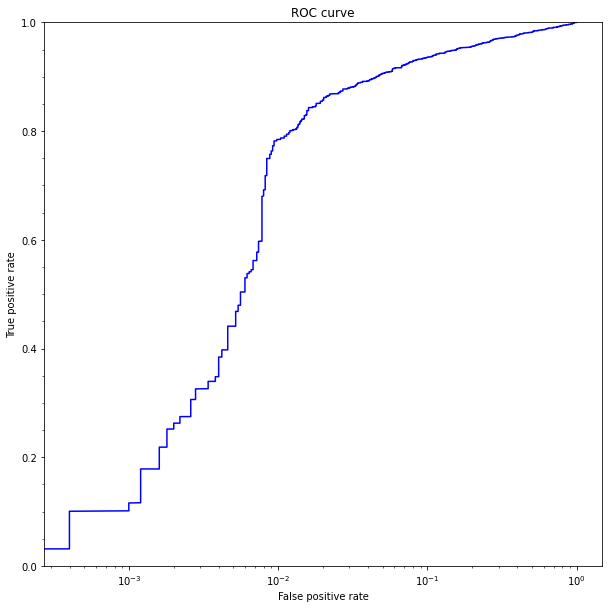

In [42]:
import matplotlib.pyplot as plt

fpr, tpr, thres = metrics.roc_curve(y_true=validation_labels, y_score=validation_scores)
fig, ax = plt.subplots(figsize=(10, 10))

plt.grid(True)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.ylim([0, 1])

ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

plt.semilogx(fpr, tpr, 'b-', label="Test set")
plt.show()
auc = metrics.auc(fpr, tpr)
print('Validation AUC = {}'.format(auc))

References

* https://towardsdatascience.com/machine-learning-part-20-dropout-keras-layers-explained-8c9f6dc4c9ab
* https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a
* https://keras.io/api/optimizers/sgd/
* https://arxiv.org/abs/1412.6980 - Adam Algorithm
* https://arxiv.org/pdf/1802.06012.pdf - WebEye– Automated Collection of Malicious HTTP Traffic